Tools  
[Write Midi Files](https://github.com/MarkCWirt/MIDIUtil)  
[Midi to CSV](https://pypi.org/project/py-midicsv/)  
[ABC Notation Player](https://github.com/mdoege/PySynth) 
[Midi to Wav](https://pypi.org/project/midi2audio/)  
[Mido <-> ABC in C](https://github.com/leesavide/abcmidi)  
[General Midi Instruments](https://en.wikipedia.org/wiki/General_MIDI#Bass)  


Resources  
[Andrej C-RNN Blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)  
[Midi File Format Info](https://www.csie.ntu.edu.tw/~r92092/ref/midi/)  
[Audio Stype Transfer Using Autoencoder](https://arxiv.org/abs/1812.07159)  



Architectures  
[C-RNN](https://github.com/karpathy/char-rnn)
[Autoencoder Example](https://www.learnopencv.com/understanding-autoencoders-using-tensorflow-python/)  


Tutorials  
[Siraj Uses Magenta](https://www.youtube.com/watch?v=pg9apmwf7og)  
[Toward Data Science Article](https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5)  

MIDI Library  
[Cprato](https://www.cprato.com)  
[Midi File Library](https://bitmidi.com)  

Notes  
CaryKH added Mozart to Bach, which doubles sample size. He then tranposed all data 6 times, one for each semitone. Then modifed Adnrej's network to 3 layers and 700 neurons each. Transposing the music up a half step makes it look like a new music (in pitch) to the network [Link](https://www.youtube.com/watch?v=SacogDL_4JU)




'commonkey.mid' - Melody, bass, and drum mapped to single 128 vectors

In [17]:
# Tools
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.auto import trange
import glob
import pickle
import seaborn as sns

# Music Related
import IPython.display as ipd
import pypianoroll
from music21 import converter, instrument, note, chord,stream



# Modeling
from keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten,GlobalAveragePooling1D,AveragePooling1D,GlobalMaxPooling1D,BatchNormalization,Activation,Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras_radam import RAdam
from sklearn.datasets import california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from lightgbm import LGBMClassifier

In [2]:
# Don't always choose the most likely prediction
def sample(preds, temperature):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Play Midi Files

In [3]:
import pygame

def play_music1(music_file):
    """
    stream music with mixer.music module in blocking manner
    this will stream the sound from disk while playing
    """
    clock = pygame.time.Clock()
    try:
        pygame.mixer.music.load(music_file)
        print ("Music file %s loaded!" % music_file)
    except pygame.error:
        print ("File %s not found! (%s)" % (music_file, pygame.get_error()))
        return
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        # check if playback has finished
        clock.tick(30)
        
def play_music(music_file):
    # Play Midi file
    try:
        play_music1(music_file)
    except KeyboardInterrupt:
        # if user hits Ctrl/C then exit
        # (works only in console mode)
        pygame.mixer.music.fadeout(1000)
        pygame.mixer.music.stop()
        raise SystemExit
        
def play_music_csv(music_csv):        
    # Parse the CSV output of the previous command back into a MIDI file
    midi_object = py_midicsv.csv_to_midi(music_csv)

    # Save the parsed MIDI file to disk
    with open("example_converted.mid", "wb") as output_file:
        midi_writer = py_midicsv.FileWriter(output_file)
        midi_writer.write(midi_object)
    play_music("example_converted.mid")

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## Run this code of midi player doesn't work

In [4]:
# Run this code of midi player doesn't work

midi_file = 'data/midi/Alan Walker - Alone  (midi by Carlo Prato) (www.cprato.com).mid'
freq = 44100    # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2    # 1 is mono, 2 is stereo
buffer = 1024    # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)
try:
    play_music(midi_file)
except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
    raise SystemExit

Music file data/midi/Alan Walker - Alone  (midi by Carlo Prato) (www.cprato.com).mid loaded!


SystemExit: 

C:\Users\matt\Anaconda3\envs\nlp\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Midi <-> CSV

## Compile data in pandas dataframe

In [2]:
import py_midicsv
import os

# Load file names
filenames = os.listdir('data/midi')
if '.DS_Store' in filenames:
    filenames.remove('.DS_Store')

filenames_clean = filenames.copy()
# Remove Unnecessary Strings
for ix,file in enumerate(filenames_clean):
    filenames_clean[ix] = filenames_clean[ix].replace('  (midi by Carlo Prato) (www.cprato.com)','')
    filenames_clean[ix] = filenames_clean[ix].replace(' (midi by Carlo Prato) (www.cprato.com)','')

# Generate Pandas Dataframe with filenames and CSV version of MIDI files
csvs = []
music_type = []
for filename in filenames:
    csvs.append(py_midicsv.midi_to_csv('data/midi/'+filename))
df_edm = pd.DataFrame({'filenames':filenames,'filenames_clean':filenames_clean,'csvs':csvs})
df_edm['filenames_clean2'] = df_edm['filenames_clean'].copy()
df_edm['filenames_clean2'] = df_edm['filenames_clean2'].apply(lambda x:x.upper())
df_edm.sort_values(by=['filenames_clean2'],inplace=True)
df_edm.drop(columns=['filenames_clean2'],inplace=True)
df_edm.reset_index(drop=True,inplace=True)

# # Parse the CSV output of the previous command back into a MIDI file
# midi_object = py_midicsv.csv_to_midi(csv_string)

# # Save the parsed MIDI file to disk
# with open("example_converted.mid", "wb") as output_file:
#     midi_writer = py_midicsv.FileWriter(output_file)
#     midi_writer.write(midi_object)

## Print indexes of instruments

In [6]:
for ix,song in enumerate(df_edm['csvs']):
    print(df_edm['filenames_clean'][ix]+' [index] : '+str(ix))
    for jx,row in enumerate(song):
        if 'Title' in row:
            print(jx,row)


Alan Walker - Alone.mid [index] : 0
8 3, 0, Title_t, "Lead"

336 4, 0, Title_t, "Bass"

640 5, 0, Title_t, "Drums"

878 6, 0, Title_t, "Alan Walker - Alone"

926 7, 0, Title_t, "Carlo Prato"

974 8, 0, Title_t, "cprato.com"

Alan Walker - Faded (Original Mix).mid [index] : 1
10 3, 0, Title_t, "Piano"

370 4, 0, Title_t, "Lead"

708 5, 0, Title_t, "Bass"

892 6, 0, Title_t, "Drums"

1138 7, 0, Title_t, "Alan Walker - Faded"

1194 8, 0, Title_t, "Carlo Prato"

1250 9, 0, Title_t, "cprato.com"

Alan Walker - Sing Me To Sleep.mid [index] : 2
8 3, 0, Title_t, "Lead"

312 4, 0, Title_t, "Bass"

440 5, 0, Title_t, "Drums"

1132 6, 0, Title_t, "Alan Walker - Sing Me To Sleep"

1180 7, 0, Title_t, "Carlo Prato"

1228 8, 0, Title_t, "cprato.com"

Calvin Harris - Blame.mid [index] : 3
8 3, 0, Title_t, "Lead"

344 4, 0, Title_t, "Bass"

648 5, 0, Title_t, "Drums"

886 6, 0, Title_t, "Calvin Harris - Blame"

934 7, 0, Title_t, "Carlo Prato"

982 8, 0, Title_t, "cprato.com"

Calvin Harris - My Way.m

## Print Header Info of All Songs

In [79]:
for i in range(len(instruments)):
    print(instruments[i][0])
    print('\n')

['0, 0, Header, 1, 8, 96\n', '1, 0, Start_track\n', '1, 0, Time_signature, 4, 2, 24, 8\n', '1, 0, End_track\n', '2, 0, Start_track\n', '2, 0, Tempo, 618557\n', '2, 0, End_track\n']


['0, 0, Header, 1, 9, 96\n', '1, 0, Start_track\n', '1, 0, Time_signature, 4, 2, 24, 8\n', '1, 0, End_track\n', '2, 0, Start_track\n', '2, 0, Tempo, 666667\n', '2, 0, Tempo, 666667\n', '2, 0, Tempo, 666667\n', '2, 0, End_track\n']


['0, 0, Header, 1, 8, 96\n', '1, 0, Start_track\n', '1, 0, Time_signature, 4, 2, 24, 8\n', '1, 0, End_track\n', '2, 0, Start_track\n', '2, 0, Tempo, 681818\n', '2, 0, End_track\n']


['0, 0, Header, 1, 8, 96\n', '1, 0, Start_track\n', '1, 0, Time_signature, 4, 2, 24, 8\n', '1, 0, End_track\n', '2, 0, Start_track\n', '2, 0, Tempo, 468750\n', '2, 0, End_track\n']


['0, 0, Header, 1, 9, 96\n', '1, 0, Start_track\n', '1, 0, Time_signature, 4, 2, 24, 8\n', '1, 0, End_track\n', '2, 0, Start_track\n', '2, 0, Tempo, 500000\n', '2, 0, End_track\n']


['0, 0, Header, 1, 9, 96\n', '1, 0,

## Parse instruments for each song

In [81]:
# For each song, break it up by instruments
instruments = []
for ix,song in enumerate(df_edm['csvs']):
    holder = []
    indexes = []
    #holder.append(df_edm['filenames_clean'][ix]+' [index] : '+str(ix))
    for jx,row in enumerate(song):
        if 'Title_t' in row:
            indexes.append(jx-1)
    # Header and info before first instrument
    holder.append(song[0:indexes[0]])
    # Add each instrument for each song
    for i in range(len(indexes)-1):
        holder.append(song[indexes[i]:indexes[i+1]])
    instruments.append(holder) 

# Index of instruments that actually has notes. This is needed to get rid of instruments that doesn't have any notes
for ix,song in enumerate(instruments):
    keep_instrument_index = []
    for jx,instrument in enumerate(song[1:]):
        note_on_off = -1
        for kx,row in enumerate(instrument):
            note_on_off = row.find('Note_on')
            if note_on_off!=-1:
                keep_instrument_index.append(jx+1)
                break
    instruments[ix]=instruments[ix][:keep_instrument_index[-1]+1]

# Extract only note_on and note_off infor for melodies, bass, and drum
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']
melody, bass, drum = [], [], []
for ix,song in enumerate(instruments):
    melody_holder, bass_holder, drum_holder = [], [], []
    for jx,instrument in enumerate(song[1:]):
        if instrument[1].split('"')[1] in bass_name:
            first_actual_note_indexes = []
            for ix,seq in enumerate(instrument):
                if ('Note_on_c' in seq) or ('Note_off_c' in seq):
                    first_actual_note_indexes.append(ix)
            bass_holder.append(instrument[first_actual_note_indexes[0]:first_actual_note_indexes[-1]+1])  
        elif instrument[1].split('"')[1] in drum_name:
            first_actual_note_indexes = []
            for ix,seq in enumerate(instrument):
                if ('Note_on_c' in seq) or ('Note_off_c' in seq):
                    first_actual_note_indexes.append(ix)
            drum_holder.append(instrument[first_actual_note_indexes[0]:first_actual_note_indexes[-1]+1])             
        else:
            first_actual_note_indexes = []
            for ix,seq in enumerate(instrument):
                if ('Note_on_c' in seq) or ('Note_off_c' in seq):
                    first_actual_note_indexes.append(ix)
            melody_holder.append(instrument[first_actual_note_indexes[0]:first_actual_note_indexes[-1]+1])
    melody.append(melody_holder)
    bass.append(bass_holder)
    drum.append(drum_holder)
    

# # Get rid of any 'Control_c','Pitch_bend_c','Program_c'
# start_end_track = []
# for ix,song in enumerate(instruments):    
#     for jx,instrument in enumerate(song):
#         remove_control_pitch_program = []
#         for kx,row in enumerate(instrument):
#             if row.split(', ')[2] not in ['Control_c','Pitch_bend_c','Program_c']:
#                 remove_control_pitch_program.append(row)
#         instruments[ix][jx] = remove_control_pitch_program  

## Play 

In [191]:
# Compile melodies across 31 songs and get unique keys being played
holder = []
for ix,song in enumerate(melody):
    for jx,instrument in enumerate(song):
        holder+=[x.split(', ') for x in instrument]  
df_all_song_melody = pd.DataFrame(holder )
# Timestamp column as integer
df_all_song_melody[1] = df_all_song_melody[1].astype('int32')
# Set the two instruments as same instrument number
df_all_song_melody[0]=3
# Set the two instruments as same instrument type
df_all_song_melody[3]=12
# Reorder df_all_song_melody by timestamp & drop duplicates
df_all_song_melody_ordered = df_all_song_melody.sort_values(by=[1]).reset_index(drop=True).copy()
df_all_song_melody_ordered.drop_duplicates(inplace=True)

# All keys across 31 songs
df_all_song_melody_ordered[4].unique()

array(['67', '55', '48', '64', '57', '71', '73', '76', '80', '74', '51',
       '41', '60', '53', '75', '68', '56', '66', '43', '69', '63', '62',
       '50', '70', '61', '78', '81', '52', '83', '72', '40', '59', '58',
       '82', '54', '65', '84', '86', '77', '42', '47', '79', '35', '45',
       '46', '87', '90', '49', '38', '39', '88', '30', '37', '89'],
      dtype=object)

In [284]:
# Process one song
song_index = 21

# Combine melodies
holder = []
for i in range(len(melody[song_index])):
    holder+=[x.split(', ') for x in melody[song_index][i]]
df_combined_instrument = pd.DataFrame(holder )
# Timestamp column as integer
df_combined_instrument[1] = df_combined_instrument[1].astype('int32')
# Set the two instruments as same instrument number
df_combined_instrument[0]=3
# Set the two instruments as same instrument type
df_combined_instrument[3]=12
# Reorder df_combined_instrument by timestamp & drop duplicates
df_combined_instrument_ordered = df_combined_instrument.sort_values(by=[1]).reset_index(drop=True).copy()
df_combined_instrument_ordered.drop_duplicates(inplace=True)
# Reconstruct ordered data into csv format to be turned into midi file
combined_instrument_ordered = []
for i in range(len(df_combined_instrument_ordered)):
    combined_instrument_ordered.append(', '.join([str(x) for x in df_combined_instrument_ordered.iloc[i].tolist()]))

# Song header and end 
song = df_edm['csvs'][song_index]
first_note_on = []
for ix,row in enumerate(song):
    if row.find('Note_on_c')!=-1:
        first_note_on.append(ix) 
song_start = song[:first_note_on[0]]    
song_end = combined_instrument_ordered[-1].split(', ')[:2]
song_end.append('End_track\n')
song_end = [', '.join(song_end)]

# Need the 'End_track' row at the end of the file so that Midi player works
csv_string = song_start+combined_instrument_ordered+song_end
play_music_csv(csv_string)

# Parse the CSV output of the previous command back into a MIDI file
midi_object = py_midicsv.csv_to_midi(csv_string)

# Save the parsed MIDI file to disk
with open("example_converted.mid", "wb") as output_file:
    midi_writer = py_midicsv.FileWriter(output_file)
    midi_writer.write(midi_object)

In [172]:
df_combined_instrument_ordered.head()

,0,1,2,3,4,5
0,3,0,Note_on_c,12,80,98\n
1,3,0,Note_on_c,12,76,98\n
2,3,0,Note_on_c,12,73,98\n
3,3,96,Note_on_c,12,80,98\n
4,3,96,Note_on_c,12,76,98\n


In [176]:
df_combined_instrument_ordered.groupby(by=[1,4],as_index=False).mean()[[1,4]]

,1,4
0,0,73
1,0,76
2,0,80
3,96,73
4,96,76
5,96,80
6,192,73
7,192,76
8,192,80
9,216,76


# Midi <-> Pianoroll

In [160]:
#!pip install pypianoroll
import pypianoroll

# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
melody,bass,drum = [[0]*128],[[0]*128],[[0]*128]
for ix,song in enumerate(df_edm['filenames'][:]): # Switch multiple songs
#for ix,song in enumerate([df_edm['filenames'].iloc[18]]): # Play a single song
    midi_loaded = pypianoroll.Multitrack('data/midi/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody = np.append(melody,melody_holder[:-120],axis=0)
    bass = np.append(bass,bass_holder[:-120],axis=0)
    drum = np.append(drum,drum_holder[:-120],axis=0)
melody = melody[1:]
bass = bass[1:]
drum = drum[1:]

# # pypianoroll's built-in merging tracks
# midi_loaded = pypianoroll.Multitrack('data/midi/'+df_edm['filenames'][0])
# midi_loaded.merge_tracks(track_indices=list(np.arange(len(midi_loaded.tracks))[:-2]), mode='sum', program=81, is_drum=False, name='merged', remove_merged=True)
# # Save to midi file and play
# pypianoroll.write(midi_loaded,'merge_tracks.mid')
# play_music("merge_tracks.mid")

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody
blank_midi.tracks[1].pianoroll = bass
blank_midi.tracks[2].pianoroll = drum

# Save to midi file and play
pypianoroll.write(blank_midi,'compiled.mid')
play_music("compiled.mid")

Music file compiled.mid loaded!


SystemExit: 

# Midi <-> Pianoroll - Adjusted (Center Notes)

In [1210]:
#!pip install pypianoroll
import pypianoroll

# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
#melody,bass,drum = [[0]*128],[[0]*128],[[0]*128]
melody,bass,drum = [],[],[]

for ix,song in enumerate(df_edm['filenames'][:]): # Switch multiple songs
#for ix,song in enumerate([df_edm['filenames'].iloc[18]]): # Play a single song
    midi_loaded = pypianoroll.Multitrack('data/midi/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody.append(melody_holder[:-120])
    bass.append(bass_holder[:-120])
    drum.append(drum_holder[:-120])

# Let first song's mean note to be note to adjust other songs to. For melody and bass only.
melody_keyss = []
for seq in melody[0]:
    melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
mean_note = int(np.mean(melody_keyss))

# Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
for ix,song in enumerate(melody):
    melody_keyss = []
    for seq in song:
        melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    current_song_mean_note = int(np.mean(melody_keyss))   
    melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
    bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i][2:]))
    bass_compiled = np.concatenate((bass_compiled,bass[i][2:]))
    drum_compiled = np.concatenate((drum_compiled,drum[i][2:]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120


blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks[1].pianoroll = bass_compiled
blank_midi.tracks[2].pianoroll = drum_compiled

# Save to midi file and play
pypianoroll.write(blank_midi,'midi/compiled_adj_with_classic.mid')
#play_music("compiled.mid")

## Find unique keys of each instrument and do analysis to fit into 128 vectors

In [14]:
# Find index of keys being played for each sequence so that it can be mapped
melody_keys = []
for seq in melody_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = [] 
    melody_keys+=seq_keys
bass_keys = []
for seq in bass_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = []
    bass_keys+=seq_keys
drum_keys = []
for seq in drum_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = []
    drum_keys+=seq_keys

print('There are {} notes in MIDI file format.'.format(len(melody_compiled[0])))
melody_keys_list = list(set(melody_keys))
bass_keys_list = list(set(bass_keys))
drum_keys_list = list(set(drum_keys))
combined_keys_num = len(melody_keys_list)+len(bass_keys_list)+len(drum_keys_list)
print('There are {} melody notes, {} bass notes, {} drum notes with total of {} notes.'.
      format(len(melody_keys_list),len(bass_keys_list),len(drum_keys_list),combined_keys_num))  
print('We will map each track notes to fall in 128 notes so that we can train our neural network')

There are 128 notes in MIDI file format.
There are 53 melody notes, 32 bass notes, 13 drum notes with total of 98 notes.
We will map each track notes to fall in 128 notes so that we can train our neural network


In [15]:
# Find index of keys being played for each sequence so that it can be mapped
melody_keys = []
for seq in melody_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = [] 
    melody_keys.append(seq_keys)
bass_keys = []
for seq in bass_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = []
    bass_keys.append(seq_keys)
drum_keys = []
for seq in drum_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = []
    drum_keys.append(seq_keys)
    

## Generate instrument's dictionaries for key <-> commonkey mapping

In [16]:
# Indexes for keys for instrument to common key mapping
commonkey = np.arange(combined_keys_num)
drumkey = commonkey[:len(drum_keys_list)]
basskey = commonkey[len(drum_keys_list):len(drum_keys_list)+len(bass_keys_list)]
melodykey = commonkey[len(drum_keys_list)+len(bass_keys_list):]

# Drum to common key in 128 notes 
drumkey_to_commonkey = defaultdict()
commonkey_to_drumkey = defaultdict()
for i in range(len(drum_keys_list)):
    drumkey_to_commonkey[drum_keys_list[i]]=commonkey[drumkey[i]]
    commonkey_to_drumkey[commonkey[drumkey[i]]]=drum_keys_list[i]
# Bass to common key in 128 notes    
basskey_to_commonkey = defaultdict()
commonkey_to_basskey = defaultdict()
for i in range(len(bass_keys_list)):
    basskey_to_commonkey[bass_keys_list[i]]=commonkey[basskey[i]]
    commonkey_to_basskey[commonkey[basskey[i]]]=bass_keys_list[i]
# Melody    
melodykey_to_commonkey = defaultdict()
commonkey_to_melodykey = defaultdict()
for i in range(len(melody_keys_list)):
    melodykey_to_commonkey[melody_keys_list[i]]=commonkey[melodykey[i]]
    commonkey_to_melodykey[commonkey[melodykey[i]]]=melody_keys_list[i]

## Generate one length x 128 vector that contains all mapped instruments (melody,bass,drum)

In [33]:
# Compile melody, bass, and drum into one length x 128 vector to generate midi file
commonkey_compiled = []
for i in trange(len(melody_compiled)):
    empty_seq = [0]*128
    for j in range(len(melody_keys[i])):
        empty_seq[melodykey_to_commonkey[melody_keys[i][j]]]=100
    for k in range(len(bass_keys[i])):
        empty_seq[basskey_to_commonkey[bass_keys[i][k]]]=100  
    for h in range(len(drum_keys[i])):
        empty_seq[drumkey_to_commonkey[drum_keys[i][h]]]=100
    commonkey_compiled.append(empty_seq)
    
# Create compiled midi's all instruments.
blank_midi = pypianoroll.Multitrack('blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
# for i in range(10):
#     commonkey_compiled[i]=[100]*128
commonkey_compiled = np.array(commonkey_compiled)
blank_midi.tracks[0].pianoroll = commonkey_compiled
blank_midi.tracks[0].program=81
blank_midi.tracks[1].pianoroll = commonkey_compiled
blank_midi.tracks[2].pianoroll = commonkey_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)
pypianoroll.write(blank_midi,'commonkey.mid')

# Reverse commonkey vector into melody, bass, and 
commonkey_compiled_keys = []
for seq in commonkey_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = []
    commonkey_compiled_keys.append(seq_keys)

100%|██████████| 57256/57256 [00:00<00:00, 223326.34it/s]


## Go back to all melody, bass, and drum from one mapped vectors

In [63]:
blank_midi = pypianoroll.Multitrack('commonkey.mid')
commonkey_compiled = blank_midi.tracks[0].pianoroll

# Reverse commonkey vector into melody, bass, and 
commonkey_compiled_keys = []
for seq in commonkey_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = []
    commonkey_compiled_keys.append(seq_keys)

In [64]:
# Generate reversed vectors for midi file generation
melody_compiled_reversed = []
bass_compiled_reversed = []
drum_compiled_reversed = []
for i in trange(len(commonkey_compiled_keys)):
    empty_seq_melody = np.array([0]*128)
    empty_seq_bass = np.array([0]*128)
    empty_seq_drum = np.array([0]*128)
    for j in range(len(commonkey_compiled_keys[i])):        
        if commonkey_compiled_keys[i][j] in commonkey_to_melodykey.keys():
            empty_seq_melody[commonkey_to_melodykey[commonkey_compiled_keys[i][j]]]=100
        elif commonkey_compiled_keys[i][j] in commonkey_to_basskey.keys():
            empty_seq_bass[commonkey_to_basskey[commonkey_compiled_keys[i][j]]]=100
        elif commonkey_compiled_keys[i][j] in commonkey_to_drumkey.keys():
            empty_seq_drum[commonkey_to_drumkey[commonkey_compiled_keys[i][j]]]=100
    melody_compiled_reversed.append(empty_seq_melody)
    bass_compiled_reversed.append(empty_seq_bass)
    drum_compiled_reversed.append(empty_seq_drum)   
    
melody_compiled_reversed = np.array(melody_compiled_reversed)
bass_compiled_reversed = np.array(bass_compiled_reversed)
drum_compiled_reversed = np.array(drum_compiled_reversed)

100%|██████████| 57264/57264 [00:02<00:00, 21972.33it/s]


## Test mapped to commonkey then reversed midi file

In [65]:
# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120

blank_midi.tracks[0].pianoroll = melody_compiled_reversed
blank_midi.tracks[1].pianoroll = bass_compiled_reversed
blank_midi.tracks[2].pianoroll = drum_compiled_reversed

# Save to midi file and play
pypianoroll.write(blank_midi,'reversed.mid')
play_music("reversed.mid")

Music file reversed.mid loaded!


SystemExit: 

# 12 Semitones

In [1211]:
# # Create compiled midi's all 6 semitones. Trying 12 semitones with long classic music didnt work...
# blank_midi = pypianoroll.Multitrack('midi/compiled_adj_with_classic.mid')
# blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
# semitone = blank_midi.tracks[0].pianoroll
# semitone_compiled = blank_midi.tracks[0].pianoroll
# semitone_list = [-3,-2,-1,1,2,3]
# for i in trange(len(semitone_list)):
#     semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
# blank_midi.tracks[0].pianoroll = semitone_compiled
# blank_midi.tracks.pop(1)
# blank_midi.tracks.pop(1)
# pypianoroll.write(blank_midi,'midi/semitone_adj_with_classic.mid')
# #play_music("semitone.mid")

In [5]:
# Create compiled midi's all 12 semitones. Then only take melody and save to semitone_adj.mid
blank_midi = pypianoroll.Multitrack('midi/compiled_adjusted.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
blank_midi.tracks[0].pianoroll = semitone_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)
pypianoroll.write(blank_midi,'midi/semitone_adj.mid')
#play_music("semitone.mid")

# Same as above but for bass
blank_midi = pypianoroll.Multitrack('midi/compiled_adjusted.mid')
blank_midi.tempo = blank_midi.tempo/blank_midi.tempo*120
semitone = blank_midi.tracks[1].pianoroll
semitone_compiled = blank_midi.tracks[1].pianoroll
semitone_list = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
blank_midi.tracks[1].pianoroll = semitone_compiled
blank_midi.tracks.pop(0)
blank_midi.tracks.pop(1)
pypianoroll.write(blank_midi,'midi/semitone_adj_bass.mid')

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.26it/s]


In [146]:
# Drum is just drum. No semition.
blank_midi = pypianoroll.Multitrack('midi/compiled_adjusted.mid')
blank_midi.tempo = blank_midi.tempo/blank_midi.tempo*120
blank_midi.tracks.pop(0)
blank_midi.tracks.pop(0)
pypianoroll.write(blank_midi,'midi/adj_drum.mid')
play_music("midi/adj_drum.mid")

Music file midi/adj_drum.mid loaded!


SystemExit: 

# Melody to Bass Mapping

In [71]:
# Create compiled midi's all 12 semitones. Then only take melody and save to semitone_adj.mid
melody_midi = pypianoroll.Multitrack('midi/semitone_adj.mid')
melody_midi.tempo = melody_midi.tempo/melody_midi.tempo*120
bass_midi = pypianoroll.Multitrack('midi/semitone_adj_bass.mid')
bass_midi.tempo = bass_midi.tempo/bass_midi.tempo*120

# pypianoroll.write(blank_midi,'midi/semitone_adj.mid')
#play_music("semitone.mid")

# Same as above but for bass
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = blank_midi.tempo/blank_midi.tempo*120
blank_midi.tracks.pop(2)
blank_midi.tracks[0].pianoroll = melody_midi.tracks[0].pianoroll
blank_midi.tracks[1].pianoroll = bass_midi.tracks[0].pianoroll

pypianoroll.write(blank_midi,'midi/semitone_adj_melody_bass.mid')

In [74]:
bass_midi.tracks[0].pianoroll

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [734]:
df_edm

,filenames,filenames_clean,csvs
0,Alan Walker - Alone (midi by Carlo Prato) (ww...,Alan Walker - Alone.mid,"[0, 0, Header, 1, 8, 96\n, 1, 0, Start_track\n..."
1,Alan Walker - Faded (Original Mix) (midi by Ca...,Alan Walker - Faded (Original Mix).mid,"[0, 0, Header, 1, 9, 96\n, 1, 0, Start_track\n..."
2,Alan Walker - Sing Me To Sleep (midi by Carlo...,Alan Walker - Sing Me To Sleep.mid,"[0, 0, Header, 1, 8, 96\n, 1, 0, Start_track\n..."
3,Calvin Harris - Blame (midi by Carlo Prato) (...,Calvin Harris - Blame.mid,"[0, 0, Header, 1, 8, 96\n, 1, 0, Start_track\n..."
4,Calvin Harris - My Way (midi by Carlo Prato) ...,Calvin Harris - My Way.mid,"[0, 0, Header, 1, 9, 96\n, 1, 0, Start_track\n..."
5,chopin_nocturne_9_2.mid,chopin_nocturne_9_2.mid,"[0, 0, Header, 1, 2, 960\n, 1, 0, Start_track\..."
6,chopin_Waltz_Opus_69_No_2_bmin.mid,chopin_Waltz_Opus_69_No_2_bmin.mid,"[0, 0, Header, 1, 2, 256\n, 1, 0, Start_track\..."
7,deadmau5 - 2448 (midi by Carlo Prato) (www.cp...,deadmau5 - 2448.mid,"[0, 0, Header, 1, 9, 96\n, 1, 0, Start_track\n..."
8,deadmau5 - Hyperlandia (midi by Carlo Prato) ...,deadmau5 - Hyperlandia.mid,"[0, 0, Header, 1, 10, 96\n, 1, 0, Start_track\..."
9,deadmau5 - No Problem (midi by Carlo Prato) (...,deadmau5 - No Problem.mid,"[0, 0, Header, 1, 10, 96\n, 1, 0, Start_track\..."


## Mapping for Char-RNN (Future work)

In [ ]:
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks[1].pianoroll = bass_compiled
blank_midi.tracks[2].pianoroll = drum_compiled

In [67]:
# Find index of keys being played for each sequence so that it can be mapped
melody_keys = []
for seq in melody_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = [1] 
    melody_keys.append(seq_keys)    
bass_keys = []
for seq in bass_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = [1]
    bass_keys.append(seq_keys)    
drum_keys = []
for seq in drum_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = [1]
    drum_keys.append(seq_keys)
    
# Key to char and char to key mapping
standard_ascii = [chr(i) for i in range(128)]
key_to_char_list = standard_ascii[32:-1]
key_to_char_list.remove('\\')
key_to_char_dict = defaultdict()
char_to_key_dict = defaultdict()
for ix,char in enumerate(key_to_char_list):
    key_to_char_dict[ix]=char
    char_to_key_dict[char]=ix
    
# Convert keys to characters using mapping
melody_chars = []
for i,seq in enumerate(melody_keys):
    holder = []
    for j,key in enumerate(seq):
        holder+=key_to_char_dict[key]
    melody_chars.append(holder)

In [497]:
# # For Andrej Karpathy's Char-RNN

# # Process one more time to be fed into char-RNN
# melody_chars_combined = ''
# for char in melody_chars:
#     melody_chars_combined+=''.join(char)+' '  

# # Save file to a txt file
# file = open('/Users/matthewlee/Desktop/Metis/char-rnn/data/tinyshakespeare/input.txt','w') 
# #file = open('input.txt','w')  
# file.write(melody_chars_combined) 
# file.close() 

# # Load txt file
# file_object  = open('input.txt','r')

In [466]:
# # Identify all keys present across melody & bass & drum. ***1 is empty sequence.
# melody_keyss = []
# for seq in melody:
#     seq_keys = []
#     seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
#     if len(seq_keys)==0:
#         seq_keys = [1] 
#     melody_keyss+=seq_keys
# bass_keyss = []
# for seq in bass:
#     seq_keys = []
#     seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
#     if len(seq_keys)==0:
#         seq_keys = [1]
#     bass_keyss+=seq_keys
    
# drum_keyss = []
# for seq in drum:
#     seq_keys = []
#     seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
#     if len(seq_keys)==0:
#         seq_keys = [1]
#     drum_keyss+=seq_keys
# list(set(melody_keyss+bass_keyss+drum_keyss))

[1,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 86,
 87,
 88,
 89,
 90]

# Follow Medium Article

In [244]:
# #!pip install music21
from music21 import converter, instrument, note, chord,stream

# Melody Portion
notes = []
for file in glob.glob("commonkey.mid"):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
pickle.dump( notes, open( "commonkey.pkl", "wb" ) )

# notes = pickle.load( open( "notes_just_adj.pkl", "rb" ) )
notes = pickle.load( open( "notes.pkl", "rb" ) )
# notes = pickle.load( open( "commonkey.pkl", "rb" ) )



# Modeling

## Train

In [153]:
# Just Melody

sequence_length = 100
n_vocab = len(list(set(notes)))
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

In [154]:
# baseline
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [155]:
filepath = "weights_drum/100_notes_drum{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=4000, batch_size=128, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/4000
 384/3159 [==>...........................] - ETA: 4:24 - loss: 3.2263

KeyboardInterrupt: 

## Load Weight and Generate Melody

As you can see, a low temperature results in extremely repetitive and predictable text, but where local structure is highly realistic: in particular, all words (a word being a local pattern of characters) are real English words. With higher temperatures, the generated text becomes more interesting, surprising, even creative; it may sometimes invent completely new words that sound somewhat plausible (such as "eterned" or "troveration"). With a high temperature, the local structure starts breaking down and most words look like semi-random strings of characters. [Link](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.1-text-generation-with-lstm.ipynb)

## Functions to load necessary files and models

In [16]:
# Don't always choose the most likely prediction
def sample(preds, temperature):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

## Load and predict Melody

#### 12 Semitones

In [4]:
from music21 import converter, instrument, note, chord,stream
#model_weight = 'weights/3-notes-adj-semitone-more-neurons3846-0.6399-bigger.hdf5
#notes = pickle.load( open( "notes.pkl", "rb" ) )

# #Classic no semi
# model_weight = 'weights/weight_3_steps_adj_classic_more_neuron15925-0.4948-bigger.hdf5' 
# notes = pickle.load( open( 'notes_just_adj_classic_no_semitone.pkl', "rb" ) )

#Classic 6 semi
model_weight = 'weights/classic_3steps_6semitone_adj04-1.3947-bigger.hdf5' 
notes = pickle.load( open( "notes_semitone_6_classic.pkl", "rb" ) )

sequence_length = 3
n_vocab = len(list(set(notes)))
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# 12 semitone
model = Sequential()
model.add(LSTM(
    512,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Load the weights
model.load_weights(model_weight)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


OSError: Unable to open file (unable to open file: name = 'weights/weight_3_steps_semitone_6_classic_more_neuron366-1.4904-bigger.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [69]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []

# generate 300 notes
#temperatures = np.arange(1.1,1.4,0.1) #Worked well with 3 ntoes np.arange(1,1.3,0.1)
#temperatures = np.arange(1.3,1.8,0.1)  #worked well with 7 notes
temperatures = [0.9,1.1,1.3,1.8,2]
temperatures = [x-0 for x in temperatures]
temperatures = [0.4]
for note_index in trange(700):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    #temperature = np.random.choice(temperatures,p=[0.7,0.15,0.1,0.04,0.01])
    index = sample(prediction[0],temperature)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offsets = [0.4,0.8]
    offset += np.random.choice(offsets,p=[0.96,0.04])
# Save midi file
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/melody_output.mid')

'midi/melody_output.mid'

In [70]:
# Play the song for semitone
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/melody_output.mid')
test_midi = pypianoroll.Multitrack('midi/melody_output.mid')
test_midi.tracks[0].pianoroll =  test_midi.tracks[0].pianoroll[:] 
test_midi.tracks[0].program=1
pypianoroll.write(test_midi,'midi/melody_output.mid')
play_music('midi/melody_output.mid')
# play_music('compiled.mid')

Music file midi/melody_output.mid loaded!


#### Just Adj

In [32]:
model_weight = 'weights/weight_3_steps_adj_classic_more_neuron15925-0.4948-bigger.hdf5'

notes = pickle.load( open( "notes_just_adj_classic_no_semitone.pkl", "rb" ) )
sequence_length = 3
n_vocab = len(list(set(notes)))
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# Melody + Bass + Drum
model = Sequential()
model.add(LSTM(
    512,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# Load the weights
model.load_weights(model_weight)

In [37]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []

# generate 300 notes
#temperatures = np.arange(1.1,1.2,0.01) #Worked well with 3 ntoes np.arange(1,1.3,0.1)
#temperatures = np.arange(1.3,1.8,0.1)  #worked well with 7 notes
temperatures = [0.9,1.1,1.3,1.8,2]
temperatures = [x+0.7 for x in temperatures]
    
for note_index in trange(800):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    temperature = np.random.choice(temperatures,p=[0.7,0.15,0.1,0.04,0.01])    
    index = sample(prediction[0],temperature)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offsets = [0.4,0.8]
    offset += np.random.choice(offsets,p=[0.98,0.02])
# Save midi file
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/melody_output.mid')

'midi/melody_output.mid'

In [38]:
# Play the song for semitone
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/melody_output.mid')
test_midi = pypianoroll.Multitrack('midi/melody_output.mid')
test_midi.tracks[0].pianoroll =  test_midi.tracks[0].pianoroll[:] 
test_midi.tracks[0].program=1
pypianoroll.write(test_midi,'midi/melody_output.mid')
play_music('midi/melody_output.mid')
# play_music('compiled.mid')

Music file midi/melody_output.mid loaded!


#### Common Keys

In [1233]:
model_weight = '100_steps_just_adj_commonkey73-0.0194-bigger.hdf5'

notes = pickle.load( open( "commonkey.pkl", "rb" ) )
sequence_length = 100
n_vocab = len(list(set(notes)))
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# Melody + Bass + Drum
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# Load the weights
model.load_weights(model_weight)

In [1234]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []
# generate 300 notes
#temperatures = np.arange(0.1,1,0.1)
temperatures = [0.2]
for note_index in trange(50):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    index = sample(prediction[0],np.random.choice(temperatures))
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]



/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [212]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.4

# Play the song for all instruments
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/test_output.mid')

test_midi = pypianoroll.Multitrack('midi/test_output.mid')
commonkey_compiled = test_midi.tracks[0].pianoroll

# Reverse commonkey vector into melody, bass, and 
commonkey_compiled_keys = []
for seq in commonkey_compiled:
    seq_keys = []
    seq_keys = [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    if len(seq_keys)==0:
        seq_keys = []
    commonkey_compiled_keys.append(seq_keys)

# Generate reversed vectors for midi file generation
melody_compiled_reversed = []
bass_compiled_reversed = []
drum_compiled_reversed = []
for i in trange(len(commonkey_compiled_keys)):
    empty_seq_melody = np.array([0]*128)
    empty_seq_bass = np.array([0]*128)
    empty_seq_drum = np.array([0]*128)
    for j in range(len(commonkey_compiled_keys[i])):        
        if commonkey_compiled_keys[i][j] in commonkey_to_melodykey.keys():
            empty_seq_melody[commonkey_to_melodykey[commonkey_compiled_keys[i][j]]]=100
        elif commonkey_compiled_keys[i][j] in commonkey_to_basskey.keys():
            empty_seq_bass[commonkey_to_basskey[commonkey_compiled_keys[i][j]]]=100
        elif commonkey_compiled_keys[i][j] in commonkey_to_drumkey.keys():
            empty_seq_drum[commonkey_to_drumkey[commonkey_compiled_keys[i][j]]]=100
    melody_compiled_reversed.append(empty_seq_melody)
    bass_compiled_reversed.append(empty_seq_bass)
    drum_compiled_reversed.append(empty_seq_drum) 




  0%|          | 0/408 [00:00<?, ?it/s]


100%|██████████| 408/408 [00:00<00:00, 10947.12it/s]

In [183]:
melody_compiled_reversed = np.array(melody_compiled_reversed)
bass_compiled_reversed = np.array(bass_compiled_reversed)
drum_compiled_reversed = np.array(drum_compiled_reversed)

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].program=81

blank_midi.tracks[0].pianoroll = melody_compiled_reversed
blank_midi.tracks[1].pianoroll = bass_compiled_reversed
blank_midi.tracks[2].pianoroll = drum_compiled_reversed

# # Only base
# blank_midi.tracks.pop(0)
# blank_midi.tracks.pop(1)

# Only drum
# blank_midi.tracks.pop(0)
# blank_midi.tracks.pop(0)

# Save to midi file and play
pypianoroll.write(blank_midi,'midi/test_output.mid')
play_music("midi/test_output.mid")

Music file midi/test_output.mid loaded!


In [177]:
blank_midi = pypianoroll.Multitrack('commonkey.mid')

In [183]:
blank_midi.tracks[0].pianoroll[2]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       100,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 100,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

## Load and predict Drum

In [16]:
from music21 import converter, instrument, note, chord,stream
model_weight = 'weights_drum/15_notes_drum2884-0.0759-bigger.hdf5'

notes_drum = pickle.load( open( "drum.pkl", "rb" ) )

sequence_length = 15
n_vocab = len(list(set(notes_drum)))
# get all pitch names
pitchnames = sorted(set(item for item in notes_drum))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes_drum) - sequence_length, 1):
    sequence_in = notes_drum[i:i + sequence_length]
    sequence_out = notes_drum[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# 12 semitone
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Load the weights
model.load_weights(model_weight)

In [17]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []
# generate 300 notes
temperatures = [0.4,0.8,1.1,1.5,2]
for note_index in trange(600):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    index = sample(prediction[0],np.random.choice(temperatures,p=[0.6,0.15,0.11,0.09,0.05]))
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [18]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.BassDrum()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.BassDrum()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offsets = [0.8,0.4]
    offset += np.random.choice(offsets,p=[0.6,0.4])
# Save midi file
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/drum_output.mid')

'midi/drum_output.mid'

In [19]:
# Play the song for semitone
test_midi = pypianoroll.Multitrack('midi/drum_output.mid')
drum_midi = pypianoroll.Multitrack('midi/blank.mid')
drum_midi.tempo = drum_midi.tempo/drum_midi.tempo*120
drum_midi.tracks[2].pianoroll = np.roll(test_midi.tracks[0].pianoroll,0)
drum_midi.tracks.pop(0)
drum_midi.tracks.pop(0)

pypianoroll.write(drum_midi,'midi/drum_output.mid')
# play_music('midi/drum_output.mid')
# play_music('compiled.mid')

/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


## Combine Melody & Drum & Bass (Todo) - 100 seq = 2.2 sec

In [26]:
# Play the song for semitone : 
melody_midi = pypianoroll.Multitrack('midi/melody_output.mid')
drum_midi = pypianoroll.Multitrack('midi/drum_output.mid')

blank_midi =  pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = blank_midi.tempo/blank_midi.tempo*115

start_index = 730
stop_index = 1320

blank_midi.tracks[0].pianoroll = np.roll(melody_midi.tracks[0].pianoroll[:],0)
number = 11
print(number)
blank_midi.tracks[0].program = number
#blank_midi.tracks[1].pianoroll =  #Bass
blank_midi.tracks[2].pianoroll = drum_midi.tracks[0].pianoroll[:len(blank_midi.tracks[0].pianoroll)]*0.8 #Cap drum length to melody's

blank_midi.tracks.pop(1) #Pop bass for now

pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid')


11
Music file midi/test.mid loaded!


SystemExit: 

#### Successes

good programs : 108, 114?, 1, 4, 8, 11, 12, 38!, 46, 53(interesting), 62, 71,80,81, 82

In [57]:
# Sucess 1. Variation of Original. 3 Notes
blank_midi =  pypianoroll.Multitrack('midi/success1.mid')
blank_midi.tracks[0].program = 1
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid') 
#play_music('data/midi/'+df_edm['filenames'][16]) - Marshmello-Alone

Music file midi/test.mid loaded!


In [56]:
# Sucess 2. Kinda like Medly.
# '3-notes-adj-semitone-more-neurons3846-0.6399-bigger.hdf5' and np.arange(1,1.3,0.1)
blank_midi =  pypianoroll.Multitrack('midi/success2.mid')
blank_midi.tracks[0].program = 0
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid') 
#play_music('data/midi/'+df_edm['filenames'][13]) - Marshmello-Alone

Music file midi/test.mid loaded!


In [124]:
# Sucess 3. MY FAVORITE, I LOVE IT@! 절묘한 mix of many songs. Can't really pinpoint any song. 
# '3-notes-adj-semitone-more-neurons3846-0.6399-bigger.hdf5' 
# temperatures = [0.8,1,1.5,2]
# temperature = np.random.choice(temperatures,p=[0.7,0.1,0.1,0.1])
blank_midi =  pypianoroll.Multitrack('midi/success3.mid')
blank_midi.tracks[0].program = 0
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid') 
#play_music('data/midi/'+df_edm['filenames'][13]) - Marshmello-Alone

Music file midi/test.mid loaded!


# Song Classifiction

## Prepare Dataframe

In [5]:
import py_midicsv
import os

# Load file names
edm_filenames = os.listdir('data/midi')
if '.DS_Store' in edm_filenames:
    edm_filenames.remove('.DS_Store')

edm_filenames_clean = edm_filenames.copy()
# Remove Unnecessary Strings
for ix,file in enumerate(edm_filenames_clean):
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace('  (midi by Carlo Prato) (www.cprato.com)','')
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace(' (midi by Carlo Prato) (www.cprato.com)','')

# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []

df_edm = pd.DataFrame({'filenames':edm_filenames,'song':edm_filenames_clean})
df_edm['filenames_clean2'] = df_edm['song'].copy()
df_edm['music_type'] = df_edm['song'].copy()
df_edm['music_type'] = 'edm'
df_edm['filenames_clean2'] = df_edm['filenames_clean2'].apply(lambda x:x.upper())
df_edm.sort_values(by=['filenames_clean2'],inplace=True)
df_edm.drop(columns=['filenames_clean2'],inplace=True)
df_edm.reset_index(drop=True,inplace=True)

# Same as above but for classic
# Load file names
classic_filenames = os.listdir('data/midi_classic')
if '.DS_Store' in classic_filenames:
    classic_filenames.remove('.DS_Store')

classic_filenames_clean = classic_filenames.copy()
# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []
df_classic = pd.DataFrame({'filenames':classic_filenames,'song':classic_filenames_clean})
df_classic['filenames_clean2'] = df_classic['song'].copy()
df_classic['music_type'] = df_classic['song'].copy()
df_classic['music_type'] = 'classic'
df_classic.sort_values(by=['filenames_clean2'],inplace=True)
df_classic.drop(columns=['filenames_clean2'],inplace=True)
df_classic.reset_index(drop=True,inplace=True)

## Classification Proof of Concept

### Train Classification Model

In [105]:
# Same as above but for classic
# Load file names
proof_filenames = os.listdir('data/midi_classification_proof')
if '.DS_Store' in proof_filenames:
    proof_filenames.remove('.DS_Store')

classic_filenames_clean = proof_filenames.copy()
# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []
df_proof = pd.DataFrame({'filenames':proof_filenames,'song':classic_filenames_clean})
df_proof['filenames_clean2'] = df_proof['song'].copy()
df_proof['music_type'] = df_proof['song'].copy()
df_proof['music_type'] = 'classic'
df_proof['music_type'].loc[0]='edm'
df_proof.sort_values(by=['filenames_clean2'],inplace=True)
df_proof.drop(columns=['filenames_clean2'],inplace=True)
df_proof.reset_index(drop=True,inplace=True)

In [106]:
#!pip install pypianoroll
import pypianoroll

# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
#melody,bass,drum = [[0]*128],[[0]*128],[[0]*128]
melody,bass,drum = [],[],[]
song_lengths = []
for ix,song in enumerate(df_proof['filenames'][:]): # Switch multiple songs
    midi_loaded = pypianoroll.Multitrack('data/midi_classification_proof/'+song)
    
    melody_holder = np.zeros((1500,128))
    bass_holder   = np.zeros((1500,128))
    drum_holder   = np.zeros((1500,128))

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll[:1500]
        elif track.name in drum_name:
            drum_holder+=track.pianoroll[:1500] 
        else:
            melody_holder+=track.pianoroll[:1500]
    melody.append(melody_holder)
    bass.append(bass_holder)
    drum.append(drum_holder)
    song_lengths.append(len(melody_holder[1:]))
    
# # Let first song's mean note to be note to adjust other songs to. For melody and bass only.
# melody_keyss = []
# for seq in melody[0]:
#     melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
# mean_note = int(np.mean(melody_keyss))

# # Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
# for ix,song in enumerate(melody):
#     melody_keyss = []
#     for seq in song:
#         melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
#     current_song_mean_note = int(np.mean(melody_keyss))   
#     melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
#     bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i][2:]))
    bass_compiled = np.concatenate((bass_compiled,bass[i][2:]))
    drum_compiled = np.concatenate((drum_compiled,drum[i][2:]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)

# semitone = blank_midi.tracks[0].pianoroll
# semitone_compiled = blank_midi.tracks[0].pianoroll
# semitone_list = [-3,-2,-1,1,2,3]
# for i in trange(len(semitone_list)):
#     semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
# blank_midi.tracks[0].pianoroll = semitone_compiled
pypianoroll.write(blank_midi,'midi/classification_proof.mid')

In [107]:
#data = pd.DataFrame(semitone_compiled)
data = pd.DataFrame(melody_compiled)

target_names = []
edm_label = [0]
classic_label = [1]
target_names+=edm_label*song_lengths[0]
target_names+=classic_label*song_lengths[1]    

data['target']=data[127]
data['target']=target_names
#data['target']=target_names*7
# Create rolling sum of 50 sequences
data[np.arange(128)] = data[np.arange(128)].rolling(50).sum()
data.dropna(inplace=True)

In [108]:
X = data[np.arange(128)]
X.columns = list(X.columns)
y = data['target']

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

gbm = xgb.XGBClassifier( 
                        n_estimators=150,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train.values,y_train),(X_val.values,y_val)]
fit_model = gbm.fit( 
                    X_train.values, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test, gbm.predict(X_test.values, ntree_limit=gbm.best_ntree_limit)) 

### Train Neural Net and Create MIDI Files

In [110]:
# #!pip install music21
from music21 import converter, instrument, note, chord,stream

# Melody Portion
notes = []
for file in glob.glob('midi/classification_proof.mid'):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
pickle.dump( notes, open( "classification_proof.pkl", "wb" ) )
notes = pickle.load( open( "classification_proof.pkl", "rb" ) )


In [128]:
sequence_length = 3
n_vocab = len(list(set(notes)))
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# Model Architecture
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(RAdam(),loss='categorical_crossentropy')

In [131]:
filepath = "weights_train/classification_proof-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=4000, batch_size=1024, callbacks=callbacks_list)

Epoch 1/4000
337/337 [==============================] - 0s 151us/step - loss: 0.2603
Epoch 2/4000
337/337 [==============================] - 0s 107us/step - loss: 0.2474
Epoch 3/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2547
Epoch 4/4000
337/337 [==============================] - 0s 116us/step - loss: 0.2541
Epoch 5/4000
337/337 [==============================] - 0s 107us/step - loss: 0.2521
Epoch 6/4000
337/337 [==============================] - 0s 128us/step - loss: 0.2507
Epoch 7/4000
337/337 [==============================] - 0s 154us/step - loss: 0.2578
Epoch 8/4000
337/337 [==============================] - 0s 172us/step - loss: 0.2507
Epoch 9/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2581
Epoch 10/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2780
Epoch 11/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2573
Epoch 12/4000
337/337 [==============================] - 0s 89us/s

Epoch 97/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2460
Epoch 98/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2239
Epoch 99/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2480
Epoch 100/4000
337/337 [==============================] - 0s 116us/step - loss: 0.2446
Epoch 101/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2596
Epoch 102/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2520
Epoch 103/4000
337/337 [==============================] - 0s 100us/step - loss: 0.2496
Epoch 104/4000
337/337 [==============================] - 0s 96us/step - loss: 0.2474
Epoch 105/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2600
Epoch 106/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2416
Epoch 107/4000
337/337 [==============================] - 0s 125us/step - loss: 0.2529
Epoch 108/4000
337/337 [=============================

Epoch 192/4000
337/337 [==============================] - 0s 162us/step - loss: 0.2494
Epoch 193/4000
337/337 [==============================] - 0s 116us/step - loss: 0.2526
Epoch 194/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2545
Epoch 195/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2467
Epoch 196/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2354
Epoch 197/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2460
Epoch 198/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2533
Epoch 199/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2409
Epoch 200/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2447
Epoch 201/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2486
Epoch 202/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2279
Epoch 203/4000
337/337 [============================

Epoch 287/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2539
Epoch 288/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2389
Epoch 289/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2479
Epoch 290/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2349
Epoch 291/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2378
Epoch 292/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2464
Epoch 293/4000
337/337 [==============================] - 0s 110us/step - loss: 0.2522
Epoch 294/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2451
Epoch 295/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2501
Epoch 296/4000
337/337 [==============================] - 0s 119us/step - loss: 0.2343
Epoch 297/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2426
Epoch 298/4000
337/337 [===========================

Epoch 382/4000
337/337 [==============================] - 0s 110us/step - loss: 0.2380
Epoch 383/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2483
Epoch 384/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2347
Epoch 385/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2285
Epoch 386/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2347
Epoch 387/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2343
Epoch 388/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2286
Epoch 389/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2430
Epoch 390/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2318
Epoch 391/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2392
Epoch 392/4000
337/337 [==============================] - 0s 116us/step - loss: 0.2490
Epoch 393/4000
337/337 [=========================

Epoch 477/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2386
Epoch 478/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2513
Epoch 479/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2353
Epoch 480/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2363
Epoch 481/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2436
Epoch 482/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2380
Epoch 483/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2440
Epoch 484/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2327
Epoch 485/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2516
Epoch 486/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2442
Epoch 487/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2594
Epoch 488/4000
337/337 [============================

Epoch 572/4000
337/337 [==============================] - 0s 96us/step - loss: 0.2434
Epoch 573/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2383
Epoch 574/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2374
Epoch 575/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2285
Epoch 576/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2345
Epoch 577/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2360
Epoch 578/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2453
Epoch 579/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2325
Epoch 580/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2241
Epoch 581/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2456
Epoch 582/4000
337/337 [==============================] - 0s 88us/step - loss: 0.2366
Epoch 583/4000
337/337 [===========================

Epoch 667/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2458
Epoch 668/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2359
Epoch 669/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2329
Epoch 670/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2331
Epoch 671/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2424
Epoch 672/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2413
Epoch 673/4000
337/337 [==============================] - 0s 107us/step - loss: 0.2406
Epoch 674/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2342
Epoch 675/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2378
Epoch 676/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2330
Epoch 677/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2282
Epoch 678/4000
337/337 [=========================

Epoch 762/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2452
Epoch 763/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2293
Epoch 764/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2387
Epoch 765/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2280
Epoch 766/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2380
Epoch 767/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2386
Epoch 768/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2530
Epoch 769/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2341
Epoch 770/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2442
Epoch 771/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2444
Epoch 772/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2504
Epoch 773/4000
337/337 [============================

Epoch 857/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2307
Epoch 858/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2452
Epoch 859/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2334
Epoch 860/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2370
Epoch 861/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2445
Epoch 862/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2480
Epoch 863/4000
337/337 [==============================] - 0s 110us/step - loss: 0.2354
Epoch 864/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2419
Epoch 865/4000
337/337 [==============================] - 0s 110us/step - loss: 0.2517
Epoch 866/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2276
Epoch 867/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2401
Epoch 868/4000
337/337 [========================

Epoch 952/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2404
Epoch 953/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2314
Epoch 954/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2469
Epoch 955/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2418
Epoch 956/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2454
Epoch 957/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2474
Epoch 958/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2483
Epoch 959/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2411
Epoch 960/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2421
Epoch 961/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2584
Epoch 962/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2642
Epoch 963/4000
337/337 [=============================

337/337 [==============================] - 0s 92us/step - loss: 0.2322
Epoch 1047/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2474
Epoch 1048/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2735
Epoch 1049/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2413
Epoch 1050/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2452
Epoch 1051/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2375
Epoch 1052/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2463
Epoch 1053/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2546
Epoch 1054/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2584
Epoch 1055/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2612
Epoch 1056/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2331
Epoch 1057/4000
337/337 [==============================] - 

337/337 [==============================] - 0s 98us/step - loss: 0.2340
Epoch 1141/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2352
Epoch 1142/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2390
Epoch 1143/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2449
Epoch 1144/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2378
Epoch 1145/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2435
Epoch 1146/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2419
Epoch 1147/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2395
Epoch 1148/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2491
Epoch 1149/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2379
Epoch 1150/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2368
Epoch 1151/4000
337/337 [==============================] 

337/337 [==============================] - 0s 98us/step - loss: 0.2347
Epoch 1235/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2448
Epoch 1236/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2448
Epoch 1237/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2418
Epoch 1238/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2412
Epoch 1239/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2242
Epoch 1240/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2578
Epoch 1241/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2535
Epoch 1242/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2416
Epoch 1243/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2331
Epoch 1244/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2401
Epoch 1245/4000
337/337 [==============================] -

337/337 [==============================] - 0s 95us/step - loss: 0.2331
Epoch 1329/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2379
Epoch 1330/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2616
Epoch 1331/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2742
Epoch 1332/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2454
Epoch 1333/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2515
Epoch 1334/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2636
Epoch 1335/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2295
Epoch 1336/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2627
Epoch 1337/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2653
Epoch 1338/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2448
Epoch 1339/4000
337/337 [==============================] - 

337/337 [==============================] - 0s 86us/step - loss: 0.2444
Epoch 1423/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2495
Epoch 1424/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2481
Epoch 1425/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2388
Epoch 1426/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2499
Epoch 1427/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2583
Epoch 1428/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2548
Epoch 1429/4000
337/337 [==============================] - 0s 107us/step - loss: 0.2368
Epoch 1430/4000
337/337 [==============================] - 0s 107us/step - loss: 0.2395
Epoch 1431/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2374
Epoch 1432/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2534
Epoch 1433/4000
337/337 [==============================

337/337 [==============================] - 0s 98us/step - loss: 0.2433
Epoch 1517/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2328
Epoch 1518/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2313
Epoch 1519/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2475
Epoch 1520/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2328
Epoch 1521/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2318
Epoch 1522/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2409
Epoch 1523/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2494
Epoch 1524/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2392
Epoch 1525/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2399
Epoch 1526/4000
337/337 [==============================] - 0s 85us/step - loss: 0.2340
Epoch 1527/4000
337/337 [==============================] - 

337/337 [==============================] - 0s 89us/step - loss: 0.2440
Epoch 1611/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2441
Epoch 1612/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2746
Epoch 1613/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2361
Epoch 1614/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2459
Epoch 1615/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2458
Epoch 1616/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2346
Epoch 1617/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2444
Epoch 1618/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2369
Epoch 1619/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2439
Epoch 1620/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2571
Epoch 1621/4000
337/337 [==============================] - 

337/337 [==============================] - 0s 92us/step - loss: 0.2355
Epoch 1705/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2364
Epoch 1706/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2552
Epoch 1707/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2437
Epoch 1708/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2579
Epoch 1709/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2357
Epoch 1710/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2435
Epoch 1711/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2292
Epoch 1712/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2427
Epoch 1713/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2602
Epoch 1714/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2336
Epoch 1715/4000
337/337 [==============================] -

337/337 [==============================] - 0s 104us/step - loss: 0.2323
Epoch 1798/4000
337/337 [==============================] - 0s 96us/step - loss: 0.2356
Epoch 1799/4000
337/337 [==============================] - 0s 110us/step - loss: 0.2470
Epoch 1800/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2483
Epoch 1801/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2375
Epoch 1802/4000
337/337 [==============================] - 0s 107us/step - loss: 0.2381
Epoch 1803/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2336
Epoch 1804/4000
337/337 [==============================] - 0s 125us/step - loss: 0.2326
Epoch 1805/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2397
Epoch 1806/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2641
Epoch 1807/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2335
Epoch 1808/4000
337/337 [============================

Epoch 1891/4000
337/337 [==============================] - 0s 190us/step - loss: 0.2281
Epoch 1892/4000
337/337 [==============================] - 0s 136us/step - loss: 0.2286
Epoch 1893/4000
337/337 [==============================] - 0s 145us/step - loss: 0.2336
Epoch 1894/4000
337/337 [==============================] - 0s 128us/step - loss: 0.2399
Epoch 1895/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2427
Epoch 1896/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2378
Epoch 1897/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2508
Epoch 1898/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2496
Epoch 1899/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2410
Epoch 1900/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2307
Epoch 1901/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2486
Epoch 1902/4000
337/337 [==============

Epoch 1985/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2653
Epoch 1986/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2455
Epoch 1987/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2647
Epoch 1988/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2535
Epoch 1989/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2535
Epoch 1990/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2654
Epoch 1991/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2374
Epoch 1992/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2303
Epoch 1993/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2735
Epoch 1994/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2543
Epoch 1995/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2485
Epoch 1996/4000
337/337 [=================

Epoch 2079/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2468
Epoch 2080/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2510
Epoch 2081/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2728
Epoch 2082/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2587
Epoch 2083/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2426
Epoch 2084/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2434
Epoch 2085/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2462
Epoch 2086/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2382
Epoch 2087/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2394
Epoch 2088/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2365
Epoch 2089/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2360
Epoch 2090/4000
337/337 [=================

Epoch 2173/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2377
Epoch 2174/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2322
Epoch 2175/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2529
Epoch 2176/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2332
Epoch 2177/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2464
Epoch 2178/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2504
Epoch 2179/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2541
Epoch 2180/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2224
Epoch 2181/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2258
Epoch 2182/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2503
Epoch 2183/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2362
Epoch 2184/4000
337/337 [=================

Epoch 2267/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2396
Epoch 2268/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2478
Epoch 2269/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2451
Epoch 2270/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2375
Epoch 2271/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2413
Epoch 2272/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2495
Epoch 2273/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2409
Epoch 2274/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2345
Epoch 2275/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2426
Epoch 2276/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2381
Epoch 2277/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2443
Epoch 2278/4000
337/337 [==================

Epoch 2361/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2341
Epoch 2362/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2395
Epoch 2363/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2505
Epoch 2364/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2492
Epoch 2365/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2437
Epoch 2366/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2517
Epoch 2367/4000
337/337 [==============================] - 0s 91us/step - loss: 0.2433
Epoch 2368/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2406
Epoch 2369/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2383
Epoch 2370/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2316
Epoch 2371/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2432
Epoch 2372/4000
337/337 [==================

Epoch 2455/4000
337/337 [==============================] - 0s 119us/step - loss: 0.2631
Epoch 2456/4000
337/337 [==============================] - 0s 128us/step - loss: 0.2486
Epoch 2457/4000
337/337 [==============================] - 0s 119us/step - loss: 0.2551
Epoch 2458/4000
337/337 [==============================] - 0s 136us/step - loss: 0.2341
Epoch 2459/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2438
Epoch 2460/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2382
Epoch 2461/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2370
Epoch 2462/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2299
Epoch 2463/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2347
Epoch 2464/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2429
Epoch 2465/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2303
Epoch 2466/4000
337/337 [===========

Epoch 2549/4000
337/337 [==============================] - 0s 104us/step - loss: 0.2391
Epoch 2550/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2550
Epoch 2551/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2400
Epoch 2552/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2262
Epoch 2553/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2364
Epoch 2554/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2373
Epoch 2555/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2358
Epoch 2556/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2806
Epoch 2557/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2294
Epoch 2558/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2516
Epoch 2559/4000
337/337 [==============================] - 0s 98us/step - loss: 0.2354
Epoch 2560/4000
337/337 [================

Epoch 2643/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2470
Epoch 2644/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2494
Epoch 2645/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2328
Epoch 2646/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2338
Epoch 2647/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2380
Epoch 2648/4000
337/337 [==============================] - 0s 92us/step - loss: 0.2628
Epoch 2649/4000
337/337 [==============================] - 0s 95us/step - loss: 0.2558
Epoch 2650/4000
337/337 [==============================] - 0s 89us/step - loss: 0.2611
Epoch 2651/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2417
Epoch 2652/4000
337/337 [==============================] - 0s 101us/step - loss: 0.2449
Epoch 2653/4000
337/337 [==============================] - 0s 86us/step - loss: 0.2685
Epoch 2654/4000
337/337 [================

KeyboardInterrupt: 

In [132]:
model.load_weights('weights_train/classification_proof-627-0.2164-bigger.hdf5')

In [133]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []

# generate 300 notes
#temperatures = np.arange(1.1,1.4,0.1) #Worked well with 3 ntoes np.arange(1,1.3,0.1)
#temperatures = np.arange(1.3,1.8,0.1)  #worked well with 7 notes
# temperatures = [0.9,1.1,1.3,1.8,2]
# temperatures = [x+2 for x in temperatures]
temperatures = [3]
for note_index in trange(300):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    #temperature = np.random.choice(temperatures,p=[0.7,0.15,0.1,0.04,0.01])
    index = sample(prediction[0],temperatures)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes1 = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes1.append(new_note)
        new_chord = chord.Chord(notes1)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offsets = [0.4,0.8]
    offset += np.random.choice(offsets,p=[0.96,0.04])
# Save midi file
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/melody_output.mid')


# Play the song for semitone
test_midi = pypianoroll.Multitrack('midi/melody_output.mid')
test_midi.tracks[0].pianoroll =  test_midi.tracks[0].pianoroll[:] 
test_midi.tempo=test_midi.tempo/test_midi.tempo*120
test_midi.tracks[0].program=1
pypianoroll.write(test_midi,'midi/melody_output.mid')

In [138]:
play_music('midi/classification_proof (2).mid')

Music file midi/classification_proof (2).mid loaded!


### Perform classification from generated MIDI file

In [135]:
blank_midi =  pypianoroll.Multitrack('midi/melody_output.mid')
test_data = pd.DataFrame(blank_midi.tracks[0].pianoroll)
test_data = test_data.rolling(50).sum()
test_data.dropna(inplace=True)
pred = gbm.predict(test_data.values, ntree_limit=gbm.best_ntree_limit)


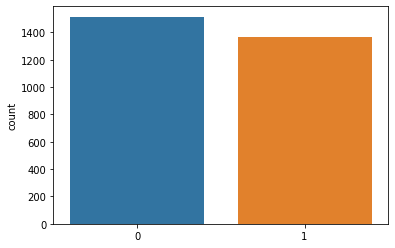

In [136]:
sns.countplot(pred)

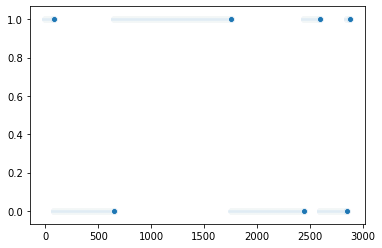

In [137]:
sns.scatterplot(np.arange(len(pred)),pred)

## Song Classification

### EDM

In [5]:
# Same as above but for classic
# Load file names
edm_filenames = os.listdir('data/midi')
if '.DS_Store' in edm_filenames:
    edm_filenames.remove('.DS_Store')

edm_filenames_clean = edm_filenames.copy()
# Remove Unnecessary Strings
for ix,file in enumerate(edm_filenames_clean):
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace('  (midi by Carlo Prato) (www.cprato.com)','')
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace(' (midi by Carlo Prato) (www.cprato.com)','')
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace('.mid','')
# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []
df_edm = pd.DataFrame({'filenames':edm_filenames,'song':edm_filenames_clean})
df_edm['filenames_clean2'] = df_edm['song'].copy()
df_edm['music_type'] = df_edm['song'].copy()
df_edm['music_type'] = 'edm'
df_edm.sort_values(by=['filenames_clean2'],inplace=True)
df_edm.drop(columns=['filenames_clean2'],inplace=True)
df_edm.reset_index(drop=True,inplace=True)

In [6]:
# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
melody,bass,drum = [],[],[]
song_names = []
for ix,song in enumerate(df_edm['filenames'][:]): # Switch multiple songs
    midi_loaded = pypianoroll.Multitrack('data/midi/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody.append(melody_holder[:-120])
    bass.append(bass_holder[:-120])
    drum.append(drum_holder[:-120])
    song_names+=[df_edm['song'][ix]]*len(melody_holder[:-120])

# Let first song's mean note to be note to adjust other songs to. For melody and bass only.
melody_keyss = []
for seq in melody[0]:
    melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
mean_note = int(np.mean(melody_keyss))

# Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
for ix,song in enumerate(melody):
    melody_keyss = []
    for seq in song:
        melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    current_song_mean_note = int(np.mean(melody_keyss))   
    melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
    bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i]))
    bass_compiled = np.concatenate((bass_compiled,bass[i]))
    drum_compiled = np.concatenate((drum_compiled,drum[i]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)

semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-3,-2,-1,1,2,3]
song_names = song_names*(len(semitone_list)+1)
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))


C:\Users\matt\Anaconda3\envs\nlp\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [7]:
data_edm = pd.DataFrame(semitone_compiled)
data_edm['target']=data_edm[127]
data_edm['target']=song_names
#data['target']=target_names*7
# Create rolling sum of 50 sequences
data_edm[np.arange(128)] = data_edm[np.arange(128)].rolling(50).sum()
data_edm.dropna(inplace=True)

### Classic

In [8]:
# Same as above but for classic
# Load file names
classic_filenames = os.listdir('data/midi_classic')
if '.DS_Store' in classic_filenames:
    classic_filenames.remove('.DS_Store')

classic_filenames_clean = classic_filenames.copy()
# Remove Unnecessary Strings
for ix,file in enumerate(classic_filenames_clean):
    classic_filenames_clean[ix] = classic_filenames_clean[ix].replace('  (midi by Carlo Prato) (www.cprato.com)','')
    classic_filenames_clean[ix] = classic_filenames_clean[ix].replace(' (midi by Carlo Prato) (www.cprato.com)','')
    classic_filenames_clean[ix] = classic_filenames_clean[ix].replace('.mid','')
# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []
df_classic = pd.DataFrame({'filenames':classic_filenames,'song':classic_filenames_clean})
df_classic['filenames_clean2'] = df_classic['song'].copy()
df_classic['music_type'] = df_classic['song'].copy()
df_classic['music_type'] = 'edm'
df_classic.sort_values(by=['filenames_clean2'],inplace=True)
df_classic.drop(columns=['filenames_clean2'],inplace=True)
df_classic.reset_index(drop=True,inplace=True)

In [9]:
# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
melody,bass,drum = [],[],[]
song_names = []
for ix,song in enumerate(df_classic['filenames'][:]): # Switch multiple songs
    midi_loaded = pypianoroll.Multitrack('data/midi_classic/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody.append(melody_holder[:-120])
    bass.append(bass_holder[:-120])
    drum.append(drum_holder[:-120])
    song_names+=[df_classic['song'][ix]]*len(melody_holder[:-120])

# Let first song's mean note to be note to adjust other songs to. For melody and bass only.
melody_keyss = []
for seq in melody[0]:
    melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
mean_note = int(np.mean(melody_keyss))

# Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
for ix,song in enumerate(melody):
    melody_keyss = []
    for seq in song:
        melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    current_song_mean_note = int(np.mean(melody_keyss))   
    melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
    bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i]))
    bass_compiled = np.concatenate((bass_compiled,bass[i]))
    drum_compiled = np.concatenate((drum_compiled,drum[i]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)

semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-3,-2,-1,1,2,3]
song_names = song_names*(len(semitone_list)+1)
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))

C:\Users\matt\Anaconda3\envs\nlp\lib\site-packages\pypianoroll\multitrack.py:726: RuntimeWarning: divide by zero encountered in true_divide
  bpm = 60. / np.diff(beat_times_one_more)


In [10]:
data_classic = pd.DataFrame(semitone_compiled)
data_classic['target']=data_classic[127]
data_classic['target']=song_names
#data['target']=target_names*7
# Create rolling sum of 50 sequences
data_classic[np.arange(128)] = data_classic[np.arange(128)].rolling(50).sum()
data_classic.dropna(inplace=True)

### Combine EDM and Classic Data

In [15]:
# Combine EDM and Classic Dataframe's 50 rolling sum and target
data_combined = pd.concat([data_edm,data_classic],ignore_index=True)

# Define X and y data. Also one-hot-encode targets
X = data_combined[np.arange(128)]
X.columns = list(X.columns)
y = data_combined['target']
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(y)


#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [18]:
scoring_list = ['accuracy', 'balanced_accuracy','f1_micro','f1_macro','f1_weighted']
hyperparameters = {'boosting_type':['gbdt'],#gbdt, gbrt, rf, random_forest, dart, goss
                   #'model__class_weight':[],
                   #'model__colsample_bytree':[0.33,0.66,1],
                   #'model__importance_type':[],
                   #'model__learning_rate':[0.01],
                   'max_depth':[-1,3,4],
                   'min_child_samples':[10,20,40], # Default 20
                   #'model__min_child_weight':[0.001], # Default 0.001
                   #'model__min_split_gain':[0], # Default 0
                   #'model__n_estimators':[100], # Default 100
                   #'model__n_jobs':[0], # Default 0. Num_threads
                   #'num_leaves':[6,15,31,62], # Default 31
                   'objective':['multiclass'],
                   'random_state':[209],
#                    'reg_alpha':[0,0.5,1], # Default 0
#                    'reg_lambda':[0,0.5,1] # Default 0
                   #'model__silent':[], # No info
                   #'model__subsample':[1], # Default 1
                   #'model__subsample_for_bin':[], # Default 200000
                   #'model__subsample_freq':[0], # Default 0
                   
                   }
lgbm = RandomizedSearchCV(estimator=LGBMClassifier(),
                             param_distributions=hyperparameters,
                             cv=3,
                             random_state=209,
                             scoring=scoring_list[4],
                             #n_iter=10,
                             verbose=2)
lgbm.fit(X_train,y_train)
with open('lgbm.pkl', 'wb') as picklefile:
    pickle.dump(lgbm, picklefile)

C:\Users\matt\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# # Initiate model
# gbm = xgb.XGBClassifier( 
#                         n_estimators=1000,
#                         max_depth=4,
#                         objective='multi:softmax', #new objective
#                         num_class =len(set(data_combined['target'])),
#                         learning_rate=.05, 
#                         subsample=.8,
#                         min_child_weight=3,
#                         colsample_bytree=.8
#                        )

# # Train data
# eval_set=[(X_train.values,y_train),(X_val.values,y_val)]
# fit_model = gbm.fit( 
#                     X_train.values, y_train, 
#                     eval_set=eval_set,
#                     eval_metric='mlogloss', #new evaluation metric: classification error (could also use AUC, e.g.)
#                     early_stopping_rounds=50,
#                     verbose=2
#                    )
# # Test on test set
# accuracy_score(y_test, gbm.predict(X_test.values, ntree_limit=gbm.best_ntree_limit)) 

[0]	validation_0-mlogloss:3.4268	validation_1-mlogloss:3.42784
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[2]	validation_0-mlogloss:3.16066	validation_1-mlogloss:3.16242
[4]	validation_0-mlogloss:2.98007	validation_1-mlogloss:2.98144
[6]	validation_0-mlogloss:2.83497	validation_1-mlogloss:2.83674


In [ ]:
with open('weights/gbm.pkl', 'wb') as picklefile:
    pickle.dump(gbm, picklefile)

## EDM vs Classic

#### EDM Processing for Classification (EDM vs Classic)

In [134]:
#!pip install pypianoroll
import pypianoroll

# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
#melody,bass,drum = [[0]*128],[[0]*128],[[0]*128]
melody,bass,drum = [],[],[]

for ix,song in enumerate(df_edm['filenames'][:]): # Switch multiple songs
    midi_loaded = pypianoroll.Multitrack('data/midi/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody.append(melody_holder[:-120])
    bass.append(bass_holder[:-120])
    drum.append(drum_holder[:-120])

# Let first song's mean note to be note to adjust other songs to. For melody and bass only.
melody_keyss = []
for seq in melody[0]:
    melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
mean_note = int(np.mean(melody_keyss))

# Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
for ix,song in enumerate(melody):
    melody_keyss = []
    for seq in song:
        melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    current_song_mean_note = int(np.mean(melody_keyss))   
    melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
    bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i][2:]))
    bass_compiled = np.concatenate((bass_compiled,bass[i][2:]))
    drum_compiled = np.concatenate((drum_compiled,drum[i][2:]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)

semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-3,-2,-1,1,2,3]
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
blank_midi.tracks[0].pianoroll = semitone_compiled
pypianoroll.write(blank_midi,'midi/classification_edm_adj_semitone.mid')

#### Classic Processing for Classification (EDM vs Classic)

In [135]:
# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
#melody,bass,drum = [[0]*128],[[0]*128],[[0]*128]
melody,bass,drum = [],[],[]

for ix,song in enumerate(df_classic['filenames'][:]): # Switch multiple songs
    midi_loaded = pypianoroll.Multitrack('data/midi_classic/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody.append(melody_holder[:-120])
    bass.append(bass_holder[:-120])
    drum.append(drum_holder[:-120])

# Let first song's mean note to be note to adjust other songs to. For melody and bass only.
melody_keyss = []
for seq in melody[0]:
    melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
#mean_note = int(np.mean(melody_keyss)) #Use EDM's mean_note

# Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
for ix,song in enumerate(melody):
    melody_keyss = []
    for seq in song:
        melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    current_song_mean_note = int(np.mean(melody_keyss))   
    melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
    bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i][2:]))
    bass_compiled = np.concatenate((bass_compiled,bass[i][2:]))
    drum_compiled = np.concatenate((drum_compiled,drum[i][2:]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)

semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-3,-2,-1,1,2,3]
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
blank_midi.tracks[0].pianoroll = semitone_compiled
pypianoroll.write(blank_midi,'midi/classification_classic_adj_semitone.mid')

/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/pypianoroll/multitrack.py:726: RuntimeWarning: divide by zero encountered in true_divide
  bpm = 60. / np.diff(beat_times_one_more)


# My own wave to MIDI

In [1183]:
import librosa
import librosa.display

In [1188]:
# Strip silence at the beginning and end of a signal
def strip(signal, frame_length=512, hop_length=256):

    # Compute RMSE.
    rmse = librosa.feature.rms(signal, frame_length=frame_length, hop_length=hop_length, center=True)
    
    # Identify the first frame index where RMSE exceeds a threshold.
    thresh = 0.004
    frame_index = 0
    while rmse[0][frame_index] < thresh:
        frame_index += 1
        
    # Convert units of frames to samples.
    start_sample_index = librosa.frames_to_samples(frame_index, hop_length=hop_length)
    
    signal = signal[start_sample_index:]    
    signal = np.array(list(signal)[::-1])
    
    # Compute RMSE.
    rmse = librosa.feature.rms(signal, frame_length=frame_length, hop_length=hop_length, center=True)
    
    # Identify the first frame index where RMSE exceeds a threshold.
    thresh = 0.004
    frame_index = 0
    while rmse[0][frame_index] < thresh:
        frame_index += 1
        
    # Convert units of frames to samples.
    start_sample_index = librosa.frames_to_samples(frame_index, hop_length=hop_length)
      
    signal = np.array(signal[start_sample_index:])
    
    # Return the trimmed signal.
    return np.array(list(signal)[::-1])

n_fft = 512
hop_length = 128

# Load file as signal & strip the silences at the beginning and at the end
signal,sr = librosa.load('output.wav',sr=22050,res_type='kaiser_fast') 
signal = strip(signal[8000:])
rms = librosa.feature.rms(y=signal,frame_length=n_fft,hop_length=hop_length)[0]

# Get top strongest RMS segments of audio file.
top_idx = np.argsort(rms)[-100:]
mean_freq_list = []
# Iterate through each strong rms segments to extract pitches
for ix,index in enumerate(top_idx):
    max_rms_frame_start = int(index/len(rms)*len(signal)-n_fft*2)
    max_rms_frame_stop = int(index/len(rms)*len(signal)+n_fft*2)
    audio_strongest_rms = signal[max_rms_frame_start:max_rms_frame_stop]
    # Auto correlate the audio in hope of removing noise and getting fundamental frequencyu
    signal_autocorr = librosa.autocorrelate(audio_strongest_rms)
    # Get pitch and magnitude of each segment
    if list(signal_autocorr):
        pitch_rms, _ = librosa.core.piptrack(y=signal_autocorr, sr=22050, n_fft=n_fft, hop_length=hop_length, fmin=50, fmax=380, threshold=0.0001, win_length=None, window='hann', center=True, pad_mode='reflect', ref=None)
        

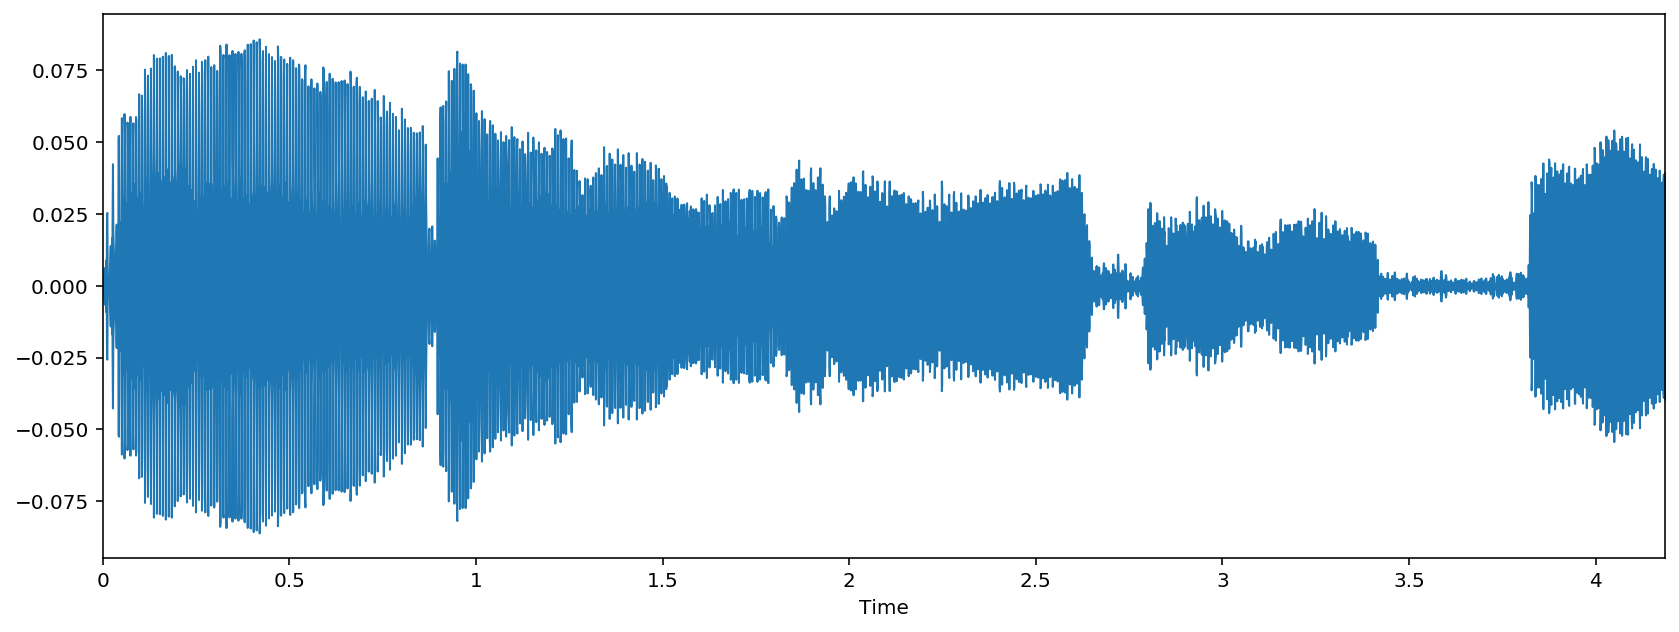

In [1189]:

plt.figure(figsize=(14, 5))
librosa.display.waveplot(signal, sr=sr)

In [1190]:
top_idx

array([100, 160, 208, 243, 113, 184, 159,  16,  35,  15,  95, 189,  91,
       106,  42,  66,  17, 174,  87,  73, 103, 213,  93,  80, 161,  37,
        34,  39,  51,  49, 172,  40, 173,  90,  92,  36,  33,  32, 162,
        44,  53, 171,  41,  43,  76,  30,  63,  84,  60,  46,  77,  50,
        48,  86,  83,  89,  54,  20,  62,  47,  18,  88,  79,  61,  56,
        28, 163,  85,  58,  78,  65,  29,  81,  19,  27,  55,  75,  67,
        70, 166,  64,  82,  74,  57, 165,  24, 170,  26,  25,  68,  72,
        69,  22, 167, 168,  21,  23,  71, 169, 164])

In [1194]:
import IPython.display as ipd
ipd.Audio('output.wav') # load a local WAV file

In [85]:
pitches = []
pitch = [0]*128
pitch[67]=100
for i in range(1):
    for j in range(50):
        pitches.append(np.roll(pitch,i))

pitch_midi =  pypianoroll.Multitrack('midi/blank.mid')
pitch_midi.tempo = pitch_midi.tempo/pitch_midi.tempo*115

pitch_midi.tracks[0].pianoroll = np.array(pitches)

pitch_midi.tracks.pop(1) #Pop bass for now
pitch_midi.tracks.pop(1) #Pop bass for now

pypianoroll.write(pitch_midi,'midi/pitch.mid')
play_music('midi/pitch.mid')



Music file midi/pitch.mid loaded!


# Pitch Tracking - Using a library

In [85]:
44100/2

22050.0

In [93]:
22050/2

11025.0

In [1125]:
# Record Audio

#!conda install -c anaconda pyaudio --yes
import pyaudio
import wave

chunk = 5012  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs =  44100  # Record at 44100 samples per second
seconds = 5
filename = "output.wav"

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Recording')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Finished recording')

# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

Recording
Finished recording


In [1126]:
# Play Audio

#!conda install -c conda-forge pydub --yes
from pydub import AudioSegment
from pydub.playback import play

song = AudioSegment.from_wav("output.wav")
play(song)

In [75]:
!audio-to-midi ./output.wav --time-window 100 --activation-level 0 #--single-note #--condense
play_music('output.wav.mid')

Converting: ./output.wav
|================================================================================| 100.00%
Music file output.wav.mid loaded!


# Download Youtube

In [156]:
# Use below command in the terminal to download youtube file as wav file.
#!python YouTube_to_WAV.py https://www.youtube.com/watch?v=xgs-laNZ0SE&t=218s

# Midi -> Wav (Doesn't work atm)

In [17]:
# #!pip install midi2audio --y
from midi2audio import FluidSynth

# using the default sound font in 44100 Hz sample rate
fs = FluidSynth()
fs.midi_to_audio('Alan Walker - Alone  (midi by Carlo Prato) (www.cprato.com) copy.mid','output.wav')
# for ix,filename in enumerate(filenames):
#     fs.midi_to_audio('data/midi/'+filename, 'data/wav/'+df_edm['filenames_clean'][ix][:-4]+'.wav')


# Play ABC Notation

In [62]:
# ABC Notation Player
import pysynth as ps

# Make test ABC file
test = (
  ('g#', 4),  ('g#', 4), ('g5', 4),
  ('g5*', 4), ('r', 4), ('e5', 16),
  ('f5', 16),  ('e5', 16),  ('d5', 16),
  ('e5*', 4) 
)
ps.make_wav(test, fn = "test.wav")

#Play wav file
ipd.Audio('test.wav') # load a local WAV file

Piano key frequencies (for equal temperament):
Key number	Scientific name	Frequency (Hz)
         1	             A0	         27.50
         2	            A#0	         29.14
         3	             B0	         30.87
         4	             C1	         32.70
         5	            C#1	         34.65
         6	             D1	         36.71
         7	            D#1	         38.89
         8	             E1	         41.20
         9	             F1	         43.65
        10	            F#1	         46.25
        11	             G1	         49.00
        12	            G#1	         51.91
        13	             A1	         55.00
        14	            A#1	         58.27
        15	             B1	         61.74
        16	             C2	         65.41
        17	            C#2	         69.30
        18	             D2	         73.42
        19	            D#2	         77.78
        20	             E2	         82.41
        21	             F2	         87.31
        22	            F#2	  